In [1]:
import sys
sys.path.append('../src/')
import itertools

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_experiment(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    df.train_BA = df.train_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.train_auroc = df.train_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_BA = df.val_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.val_auroc = df.val_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_BA = df.test_BA.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    df.test_auroc = df.test_auroc.apply(lambda string: np.fromstring(string[1:-1], sep=' '))
    return df

In [167]:
def get_alpha(n):
    if n <= 360:
        return 1.0
    else:
        return 0.3
    
def get_facecolors(n):
    return 'none'

def plot_experiment(df, labels):
    fig, axs = plt.subplots(ncols=len(labels), nrows=1, figsize=(12, 3), dpi=300)
    for label_index, _ in enumerate(labels):
        scatter1_ = axs[label_index].scatter(df.n[df.random_state==1001].to_numpy(),
                                 np.array(df.test_auroc[df.random_state==1001].to_list())[:,label_index],
                                 color = '#1f77b4',
                                 alpha=list(map(get_alpha, df.n[df.random_state==1001].to_list())),
                                 label='seed 1001')
        scatter2_ = axs[label_index].scatter(df.n[df.random_state==2001].to_numpy(),
                                 np.array(df.test_auroc[df.random_state==2001].to_list())[:,label_index],
                                 color = '#2ca02c',
                                 alpha=list(map(get_alpha, df.n[df.random_state==2001].to_list())),
                                 label='seed 2001')     
        scatter3_ = axs[label_index].scatter(df.n[df.random_state==3001].to_numpy(),
                                 np.array(df.test_auroc[df.random_state==3001].to_list())[:,label_index],
                                 color = '#ff7f0e',
                                 alpha=list(map(get_alpha, df.n[df.random_state==3001].to_list())),
                                 label='seed 3001') 
        axs[label_index].set_ylim([0.5, 1.0])
        axs[label_index].set_xscale('log')
        axs[label_index].set_xlabel('Number of training samples')
        axs[label_index].set_ylabel('{} AUROC'.format(labels[label_index]))
        axs[label_index].legend(loc='lower right')
    fig.tight_layout()
    plt.show()

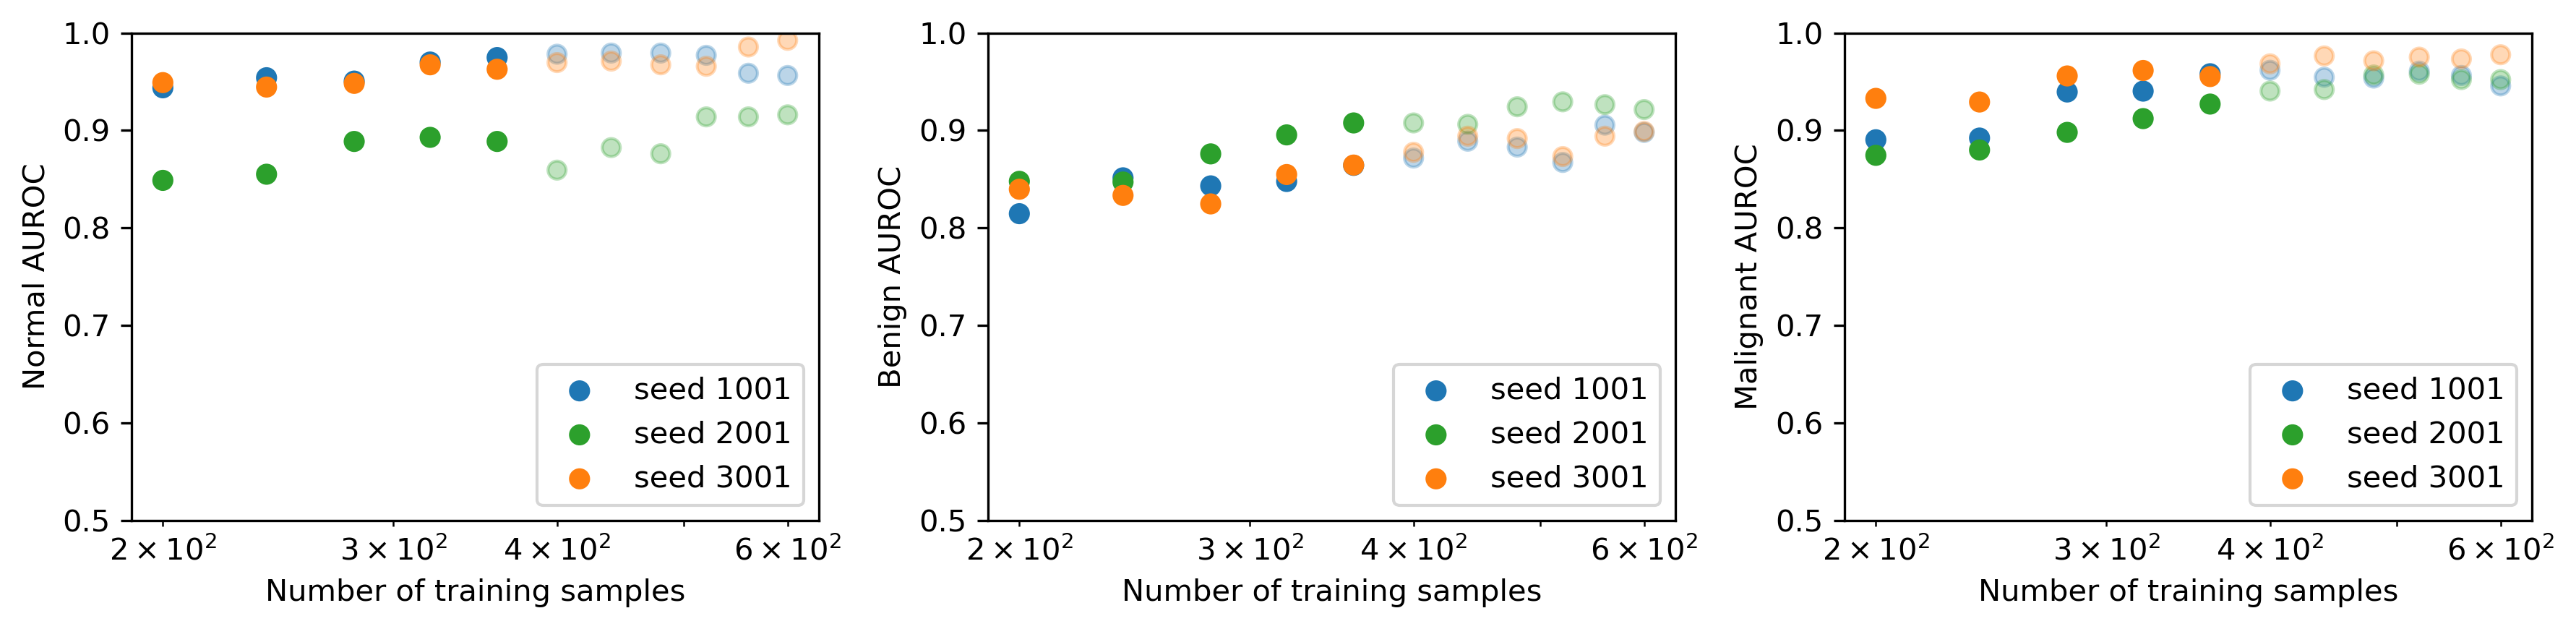

In [168]:
# Breast Ultrasound Dataset
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Breast_Ultrasound_Dataset_short_range.csv')
plot_experiment(df, ['Normal', 'Benign', 'Malignant'])

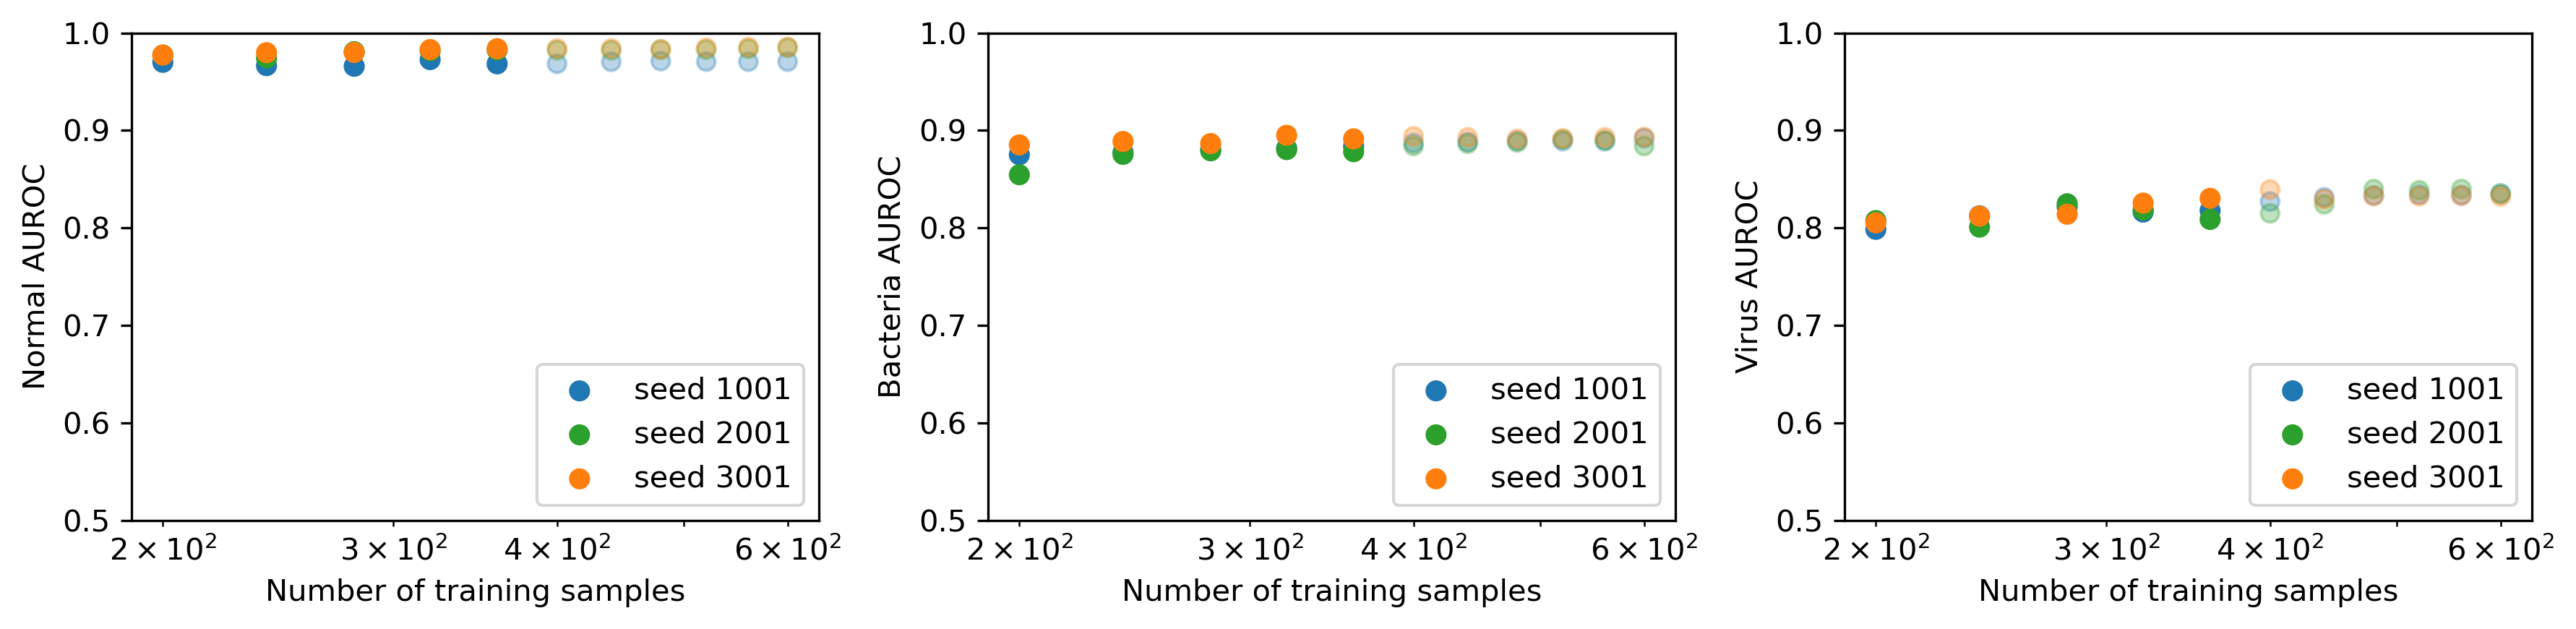

In [169]:
# Chest X-Ray (short range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_short_range.csv')
plot_experiment(df, ['Normal', 'Bacteria', 'Virus'])

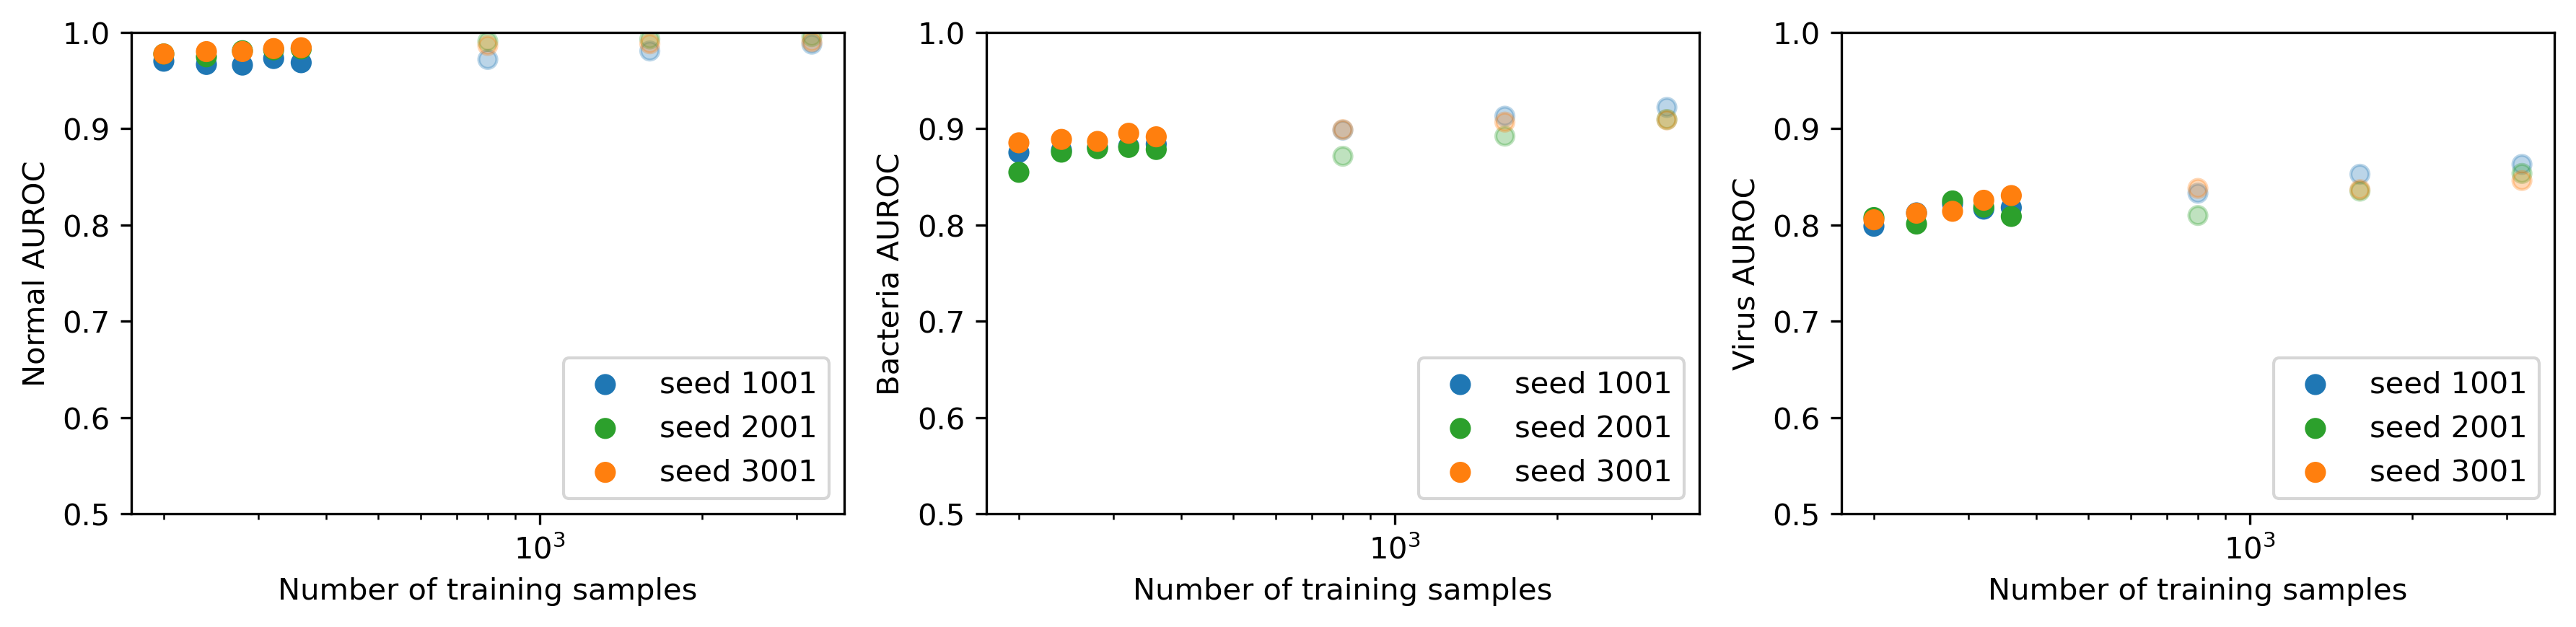

In [170]:
# Chest X-Ray (long range)
df = load_experiment('/cluster/home/eharve06/extrapolating-classifier-accuracy-to-bigger-datasets/experiments/Chest_X-Ray_long_range.csv')
plot_experiment(df, ['Normal', 'Bacteria', 'Virus'])